# **Problem Statement:**

- The major objective of this project is to extract actionable insights from the historical match data and make strategic changes to make India win. 
- Primary objective is to create Machine Learning models which correctly predicts a win for the Indian Cricket Team. 
- Once a model is developed then you have to extract actionable insights and recommendation. Also, below are the details of the next 10 matches, India is going to play. You have to predict the result of the matches.


In [42]:
!pip install optuna
!pip install xgboost

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use("fivethirtyeight")

from sklearn.model_selection import KFold,StratifiedKFold, train_test_split

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from xgboost import  XGBClassifier


import optuna

In [44]:
# If read.excel doesnt work uncomment and run following code.
!pip install xlrd



# **Loading the data**

### Data Dictionary

In [45]:
df_metadata = pd.read_excel('/content/Sports Data.xlsx', sheet_name = 'Meta data', header = 1, usecols = [1,2])
df_metadata

,Variables,Description
0,Game_number,Unique ID for each match
1,Result,Final result of the match
2,Avg_team_Age,Average age of the playing 11 players for that...
3,Match_light_type,"type of match: Day, night or day & night"
4,Match_format,"Format of the match: T20, ODI or test"
5,Bowlers_in_team,how many full time bowlers has been player in ...
6,Wicket_keeper_in_team,how many full time wicket keeper has been play...
7,All_rounder_in_team,how many full time all rounder has been player...
8,First_selection,First inning of team: batting or bowling
9,Opponent,Opponent team in the match


## Data set

In [46]:
df_maindata_excel = pd.read_excel('/content/Sports Data.xlsx', sheet_name = 'Sports data for DSBA')
df_maindata_excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Game_number             2930 non-null   object 
 1   Result                  2930 non-null   object 
 2   Avg_team_Age            2833 non-null   float64
 3   Match_light_type        2878 non-null   object 
 4   Match_format            2860 non-null   object 
 5   Bowlers_in_team         2848 non-null   float64
 6   Wicket_keeper_in_team   2930 non-null   int64  
 7   All_rounder_in_team     2890 non-null   float64
 8   First_selection         2871 non-null   object 
 9   Opponent                2894 non-null   object 
 10  Season                  2868 non-null   object 
 11  Audience_number         2849 non-null   float64
 12  Offshore                2866 non-null   object 
 13  Max_run_scored_1over    2902 non-null   float64
 14  Max_wicket_taken_1over  2930 non-null   

## **Creating StratifyKFold columns in the dataset, which will be used to create train, validation split in later stages.**

In [47]:
df_maindata_excel["kfold"] = -1

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_indicies, valid_indicies) in enumerate(skf.split(df_maindata_excel, df_maindata_excel.Result)):
    df_maindata_excel.loc[valid_indicies, "kfold"] = fold

df_maindata_excel.to_csv("maindata_folds.csv", index=False)

In [48]:
df_maindata = pd.read_csv('maindata_folds.csv')
df_maindata.head()

,Game_number,Result,Avg_team_Age,Match_light_type,Match_format,Bowlers_in_team,Wicket_keeper_in_team,All_rounder_in_team,First_selection,Opponent,Season,Audience_number,Offshore,Max_run_scored_1over,Max_wicket_taken_1over,Extra_bowls_bowled,Min_run_given_1over,Min_run_scored_1over,Max_run_given_1over,extra_bowls_opponent,player_highest_run,Players_scored_zero,player_highest_wicket,kfold
0,Game_1,Loss,18.0,Day,ODI,3.0,1,3.0,Bowling,Srilanka,Summer,9940.0,No,13.0,3,0.0,2,3.0,6.0,0,54.0,3,1,0
1,Game_2,Win,24.0,Day,T20,3.0,1,4.0,Batting,Zimbabwe,Summer,8400.0,No,12.0,1,0.0,0,3.0,6.0,0,69.0,2,1,0
2,Game_3,Loss,24.0,Day and Night,T20,3.0,1,2.0,Bowling,Zimbabwe,NaN,13146.0,Yes,14.0,4,0.0,0,3.0,6.0,0,69.0,3,1,0
3,Game_4,Win,24.0,NaN,ODI,2.0,1,2.0,Bowling,Kenya,Summer,7357.0,No,15.0,4,0.0,2,3.0,6.0,0,73.0,3,1,4
4,Game_5,Loss,24.0,Night,ODI,1.0,1,3.0,Bowling,Srilanka,Summer,13328.0,No,12.0,4,0.0,0,3.0,6.0,0,80.0,3,1,0


In [49]:
df_maindata.shape

(2930, 24)

In [50]:
df_maindata.describe()

,Avg_team_Age,Bowlers_in_team,Wicket_keeper_in_team,All_rounder_in_team,Audience_number,Max_run_scored_1over,Max_wicket_taken_1over,Extra_bowls_bowled,Min_run_given_1over,Min_run_scored_1over,Max_run_given_1over,extra_bowls_opponent,player_highest_run,kfold
count,2833.000000,2848.000000,2930.0,2890.000000,2.849000e+03,2902.000000,2930.000000,2901.000000,2930.000000,2903.000000,2896.000000,2930.000000,2902.000000,2930.000000
mean,29.242852,2.913624,1.0,2.722491,4.626796e+04,15.199862,2.713993,11.252671,1.952560,2.762659,8.669199,4.229693,65.889387,2.000000
std,2.264230,1.023907,0.0,1.092699,4.859958e+04,3.661010,1.080623,7.780829,1.678332,0.705759,5.003525,3.626108,20.331614,1.414455
min,12.000000,1.000000,1.0,1.000000,7.063000e+03,11.000000,1.000000,0.000000,0.000000,1.000000,6.000000,0.000000,30.000000,0.000000
25%,30.000000,2.000000,1.0,2.000000,2.036300e+04,12.000000,2.000000,6.000000,0.000000,2.000000,6.000000,2.000000,48.000000,1.000000
50%,30.000000,3.000000,1.0,3.000000,3.434900e+04,14.000000,3.000000,10.000000,2.000000,3.000000,6.000000,3.000000,66.000000,2.000000
75%,30.000000,4.000000,1.0,4.000000,5.787600e+04,18.000000,4.000000,15.000000,3.000000,3.000000,9.250000,7.000000,84.000000,3.000000
max,70.000000,5.000000,1.0,4.000000,1.399930e+06,25.000000,4.000000,40.000000,6.000000,4.000000,40.000000,18.000000,100.000000,4.000000


In [51]:
df_maindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Game_number             2930 non-null   object 
 1   Result                  2930 non-null   object 
 2   Avg_team_Age            2833 non-null   float64
 3   Match_light_type        2878 non-null   object 
 4   Match_format            2860 non-null   object 
 5   Bowlers_in_team         2848 non-null   float64
 6   Wicket_keeper_in_team   2930 non-null   int64  
 7   All_rounder_in_team     2890 non-null   float64
 8   First_selection         2871 non-null   object 
 9   Opponent                2894 non-null   object 
 10  Season                  2868 non-null   object 
 11  Audience_number         2849 non-null   float64
 12  Offshore                2866 non-null   object 
 13  Max_run_scored_1over    2902 non-null   float64
 14  Max_wicket_taken_1over  2930 non-null   

Observations:

---


- There are missing values. Check them and treat them accordingly
- Player_hightest_wicket and Players_scored_zero is object type convert it into int as it might be useful as int


In [52]:
"""Making columns lower case and replacing any spaces with '_'"""
df_maindata.columns = df_maindata.columns.str.lower().str.replace(' ', '_')

## **Check unique values and convert required columns into Integer type:**

---


- Check the unique values 
- If all values are int then we change it to integer
- Else we convert any string values to int and then convert all values into int type.

In [53]:
for col in df_maindata.columns:
  print(col, '\n',df_maindata[col].unique())
  print()

game_number 
 ['Game_1' 'Game_2' 'Game_3' ... 'Game_2928' 'Game_2929' 'Game_2930']

result 
 ['Loss' 'Win']

avg_team_age 
 [18. 24. nan 17. 12. 25. 26. 27. 28. 29. 30. 70. 69. 50.]

match_light_type 
 ['Day' 'Day and Night' nan 'Night']

match_format 
 ['ODI' 'T20' 'Test' '20-20' nan]

bowlers_in_team 
 [ 3.  2.  1. nan  4.  5.]

wicket_keeper_in_team 
 [1]

all_rounder_in_team 
 [ 3.  4.  2.  1. nan]

first_selection 
 ['Bowling' 'Batting' 'Bat' nan]

opponent 
 ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England' 'South Africa'
 'Pakistan' 'West Indies' 'Bangladesh' nan]

season 
 ['Summer' nan 'Winter' 'Rainy']

audience_number 
 [ 9940.  8400. 13146. ... 20937. 28756. 14007.]

offshore 
 ['No' 'Yes' nan]

max_run_scored_1over 
 [13. 12. 14. 15. 16. 19. 21. 22. 25. 18. 11. 17. 24. 20. nan 23.]

max_wicket_taken_1over 
 [3 1 4 2]

extra_bowls_bowled 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 17. 31. 13. 26. 24.
 22. 19. 23. 14. 15. 29. 28. 21. 25. 20. 16. 37. 38. 30. 40.

### **Observations:**

---


- Variables like player_highest_wicket, players_scored_zero, match_format, first_selection has repeated unique values. 
- E.g. player_highest_wicket has 'Three' and 3, which actually means the same. Hence, we will replace 'Three' by 3.
- Similarly for the other variables.
- Finally convert player_hightest_wicket and players_scored_zero to integer

In [54]:
"""Replacing repeated values"""

df_maindata['player_highest_wicket'] = df_maindata['player_highest_wicket'].apply(lambda x: x if (x != 'Three') else 3)
df_maindata['players_scored_zero'] = df_maindata['players_scored_zero'].apply(lambda x: x if (x != 'Three') else 3)
df_maindata['match_format'] = df_maindata['match_format'].apply(lambda x: x if (x != '20-20') else 'T20')
df_maindata['first_selection'] = df_maindata['first_selection'].apply(lambda x: x if (x != 'Bat') else 'Batting')


"""Converting player_highest_wicket and players_scored_zero to integer"""
df_maindata['player_highest_wicket'] = df_maindata['player_highest_wicket'].astype('int')
df_maindata['players_scored_zero'] = df_maindata['players_scored_zero'].astype('int')

for col in df_maindata.columns:
  print(col, '\n',df_maindata[col].unique())
  print()

game_number 
 ['Game_1' 'Game_2' 'Game_3' ... 'Game_2928' 'Game_2929' 'Game_2930']

result 
 ['Loss' 'Win']

avg_team_age 
 [18. 24. nan 17. 12. 25. 26. 27. 28. 29. 30. 70. 69. 50.]

match_light_type 
 ['Day' 'Day and Night' nan 'Night']

match_format 
 ['ODI' 'T20' 'Test' nan]

bowlers_in_team 
 [ 3.  2.  1. nan  4.  5.]

wicket_keeper_in_team 
 [1]

all_rounder_in_team 
 [ 3.  4.  2.  1. nan]

first_selection 
 ['Bowling' 'Batting' nan]

opponent 
 ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England' 'South Africa'
 'Pakistan' 'West Indies' 'Bangladesh' nan]

season 
 ['Summer' nan 'Winter' 'Rainy']

audience_number 
 [ 9940.  8400. 13146. ... 20937. 28756. 14007.]

offshore 
 ['No' 'Yes' nan]

max_run_scored_1over 
 [13. 12. 14. 15. 16. 19. 21. 22. 25. 18. 11. 17. 24. 20. nan 23.]

max_wicket_taken_1over 
 [3 1 4 2]

extra_bowls_bowled 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 17. 31. 13. 26. 24.
 22. 19. 23. 14. 15. 29. 28. 21. 25. 20. 16. 37. 38. 30. 40. 18. 36. 34.
 

In [55]:
df_maindata.isnull().sum().to_frame().rename({0: 'Missing Values'}, axis = 1).sort_values(by = 'Missing Values', ascending = False).style.background_gradient('copper_r')

,Missing Values
avg_team_age,97
bowlers_in_team,82
audience_number,81
match_format,70
offshore,64
season,62
first_selection,59
match_light_type,52
all_rounder_in_team,40
opponent,36


,%age of Missing Values
avg_team_age,0.033110
bowlers_in_team,0.027990
audience_number,0.027650
match_format,0.023890
offshore,0.021840
season,0.021160
first_selection,0.020140
match_light_type,0.017750
all_rounder_in_team,0.013650
opponent,0.012290


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



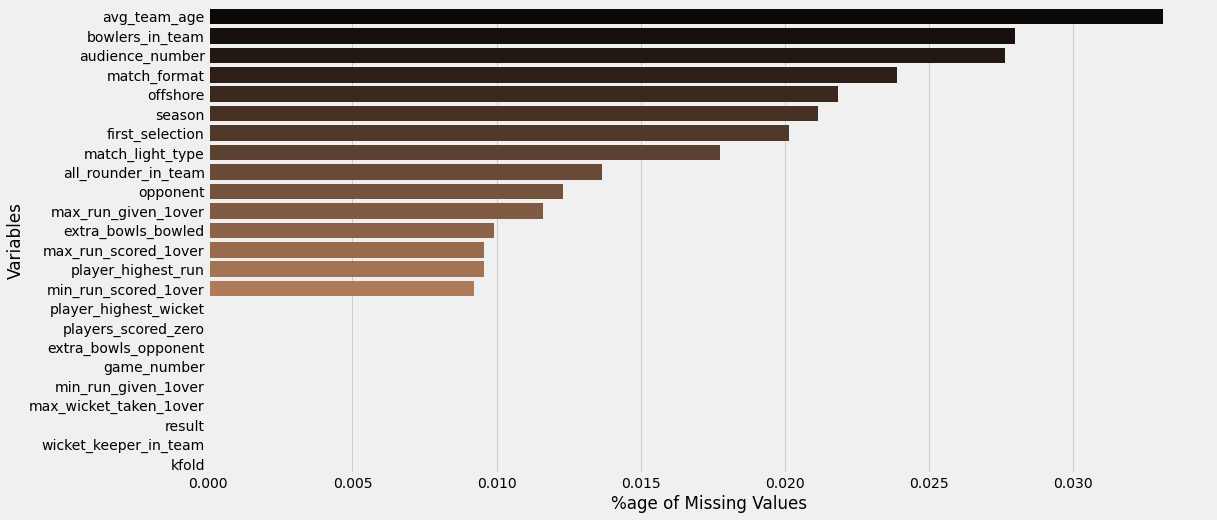

In [56]:
"""Percentage of Missing Values"""
percentage = df_maindata.isnull().mean().round(5).to_frame().rename({0: '%age of Missing Values'}, axis = 1).sort_values(by = '%age of Missing Values', ascending = False)
display(percentage.style.background_gradient('copper_r'))

"""Setting for displaying plot"""
plot_percentage = percentage.reset_index().rename({"index": "Variables"}, axis = 1)
# order = percentage.isnull().mean().round(2).sort_values(ascending =False).index
ax = sns.barplot(plot_percentage['%age of Missing Values'], plot_percentage['Variables'], palette = 'copper')
plt.show()

Observations:
- Missing values in Avg_team_Age, Bowlers_in_team, Audience_number,Match_format ,Offshore, Season,First_selection, Match_light_type ,All_rounder_in_team, Opponent,Max_run_given_1over, Extra_bowls_bowled,player_highest_run,Max_run_scored_1over, Min_run_scored_1over Treat them accordingly
- Avg_team_Age has highest number of missing values.
- **Missing value in Opponent cannot be filled with mode as it might bias our result towards. Best option is to drop those rows**

In [57]:
missing_values_cols = list(plot_percentage[plot_percentage['%age of Missing Values'] != 0]['Variables']) 
missing_cat_cols = [col for col in missing_values_cols if df_maindata[col].dtype == 'object']
missing_num_cols = [col for col in missing_values_cols if col not in missing_cat_cols]
missing_cat_cols

['match_format',
 'offshore',
 'season',
 'first_selection',
 'match_light_type',
 'opponent']

In [58]:
"""Drop rows with missing values in Opponent"""
df_maindata.dropna(subset=['opponent'], inplace = True)

# Now removing Opponent col from list of categorical colummns
missing_cat_cols.remove('opponent')                     

"""Impute Mode for categorical columns"""
for col in missing_cat_cols:
    df_maindata[col].fillna(value=df_maindata[col].mode()[0],inplace=True)

"""Impute mean for numerical columns"""
for col in missing_num_cols:
    df_maindata[col].fillna(value=df_maindata[col].median(),inplace=True)

In [59]:
df_maindata.isnull().sum().to_frame().rename({0: 'Missing Values'}, axis = 1).sort_values(by = 'Missing Values', ascending = False).style.background_gradient('copper_r')

,Missing Values
game_number,0
result,0
player_highest_wicket,0
players_scored_zero,0
player_highest_run,0
extra_bowls_opponent,0
max_run_given_1over,0
min_run_scored_1over,0
min_run_given_1over,0
extra_bowls_bowled,0


Observations:
- Dropped the rows with missing values in Opponent Col 
- Imputed categorical missing values using mode
- Imputed numerical missing values using mean

## **Duplicates?**

In [60]:
df_maindata.duplicated().sum()

0

## **Any Constant Features? They show same value or just one value for all the records in the dataset.**

In [61]:
# Checking constant variables
constant_features = [col for col in df_maindata.columns if df_maindata[col].nunique() == 1]
constant_features

['wicket_keeper_in_team']

In [62]:
# Dropping the constant feature
del df_maindata['wicket_keeper_in_team']

## **Correlation**

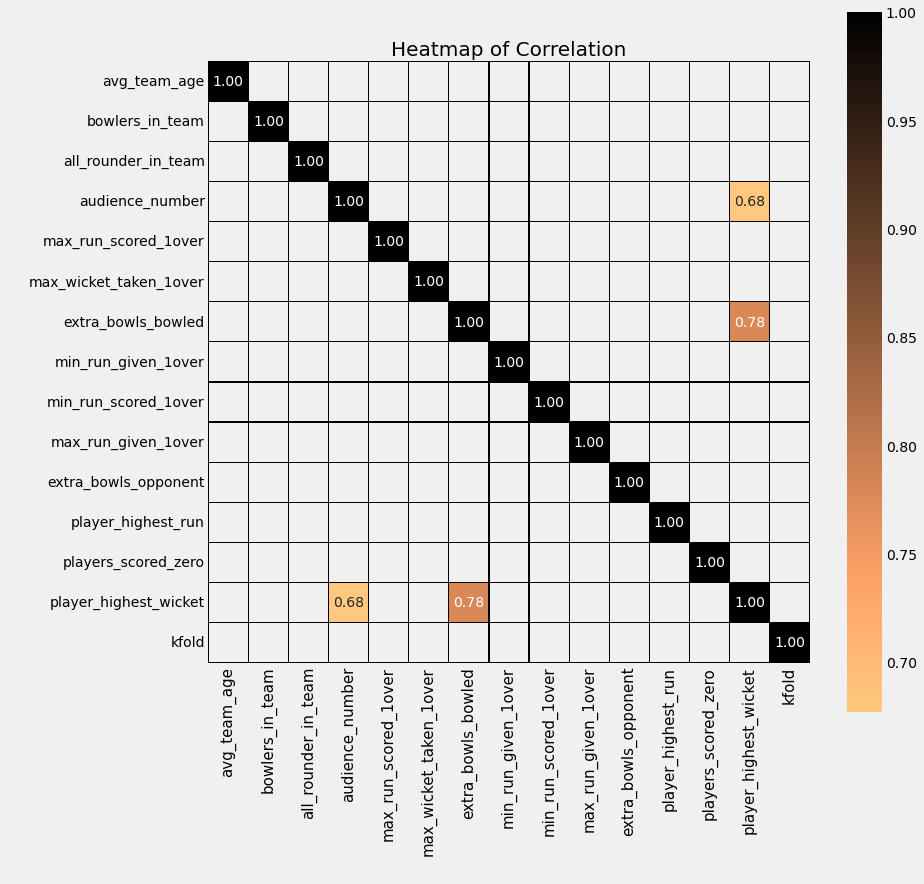

In [63]:
plt.figure(figsize=(12,12))
ax = sns.heatmap(df_maindata.corr(), annot = True, fmt='.2f', mask = df_maindata.corr() < .65, square = True, lw=0.2,linecolor='black' , cmap = 'copper_r')
plt.title("Heatmap of Correlation",fontsize = 20)
plt.xlabel(" ")
plt.ylabel(" ")
plt.xticks(fontsize = 15)
plt.show();

Observations:
- Wicket_keeper_in_team has only one value. Hence we can drop that variable
- Multicollinearity exists between player_highest_wicket and (audience number and extra bowls bowled) at 0.65 as threshold.
- Drop audience number and extra bowls bowled

In [64]:
df_maindata.drop(['audience_number', 'extra_bowls_bowled'], axis = 1, inplace=True)

## **Plotting Categorical Fetures**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



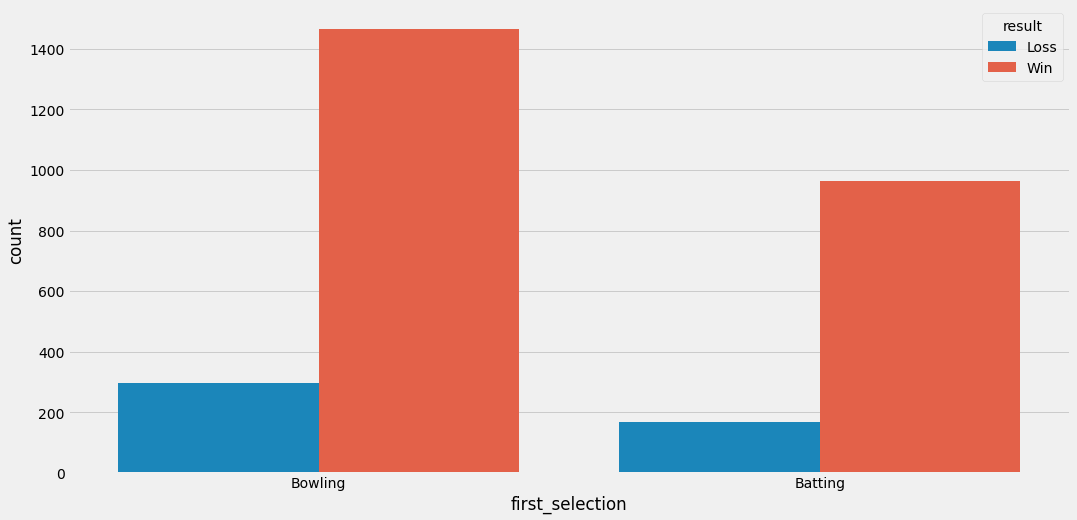

In [65]:
sns.countplot('first_selection', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



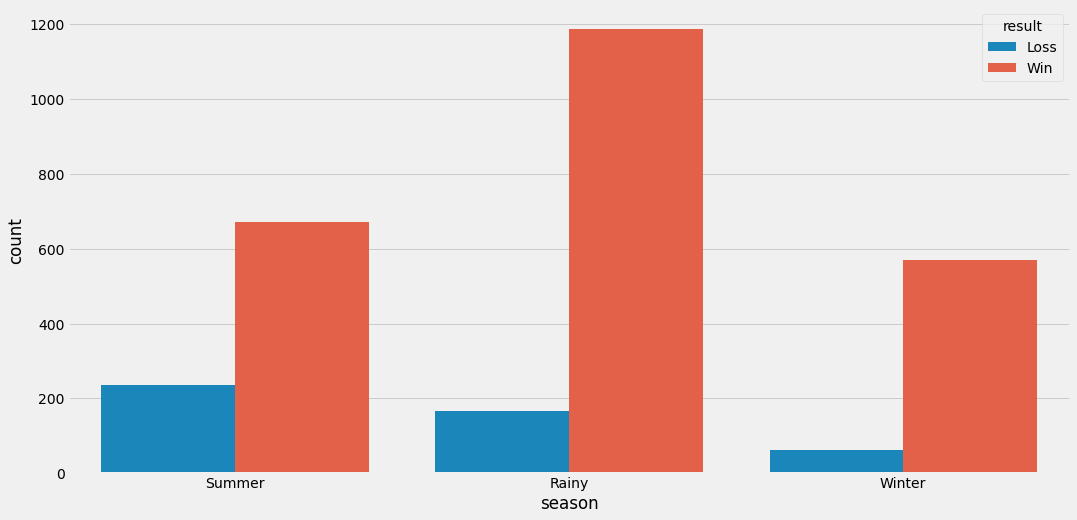

In [66]:
sns.countplot('season', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



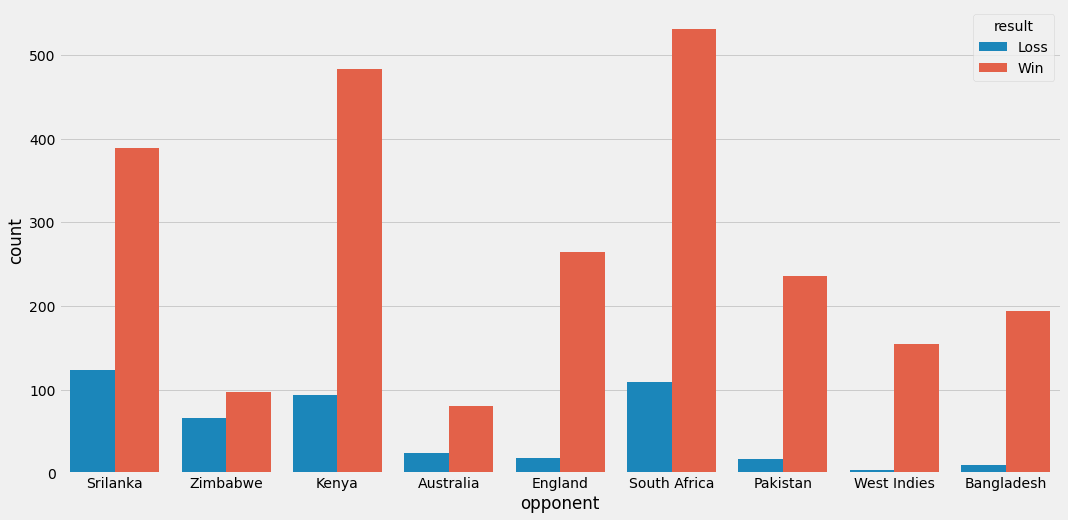

In [67]:
sns.countplot('opponent', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



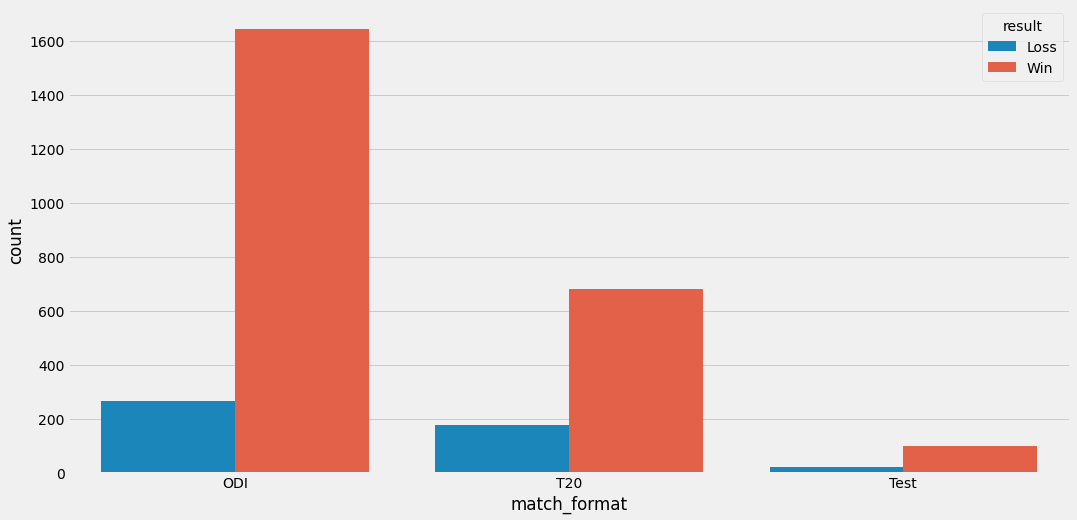

In [68]:
sns.countplot('match_format', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



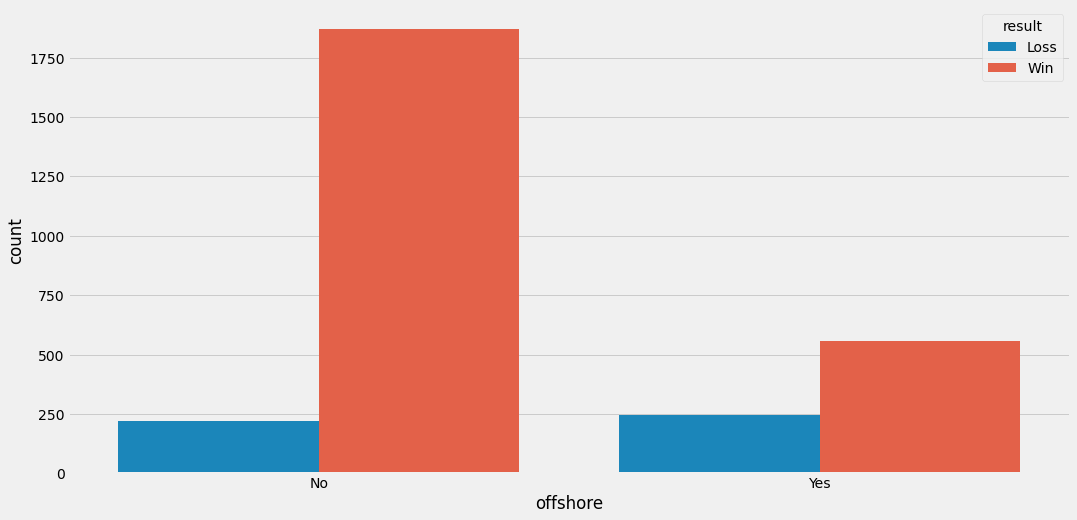

In [69]:
sns.countplot('offshore', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



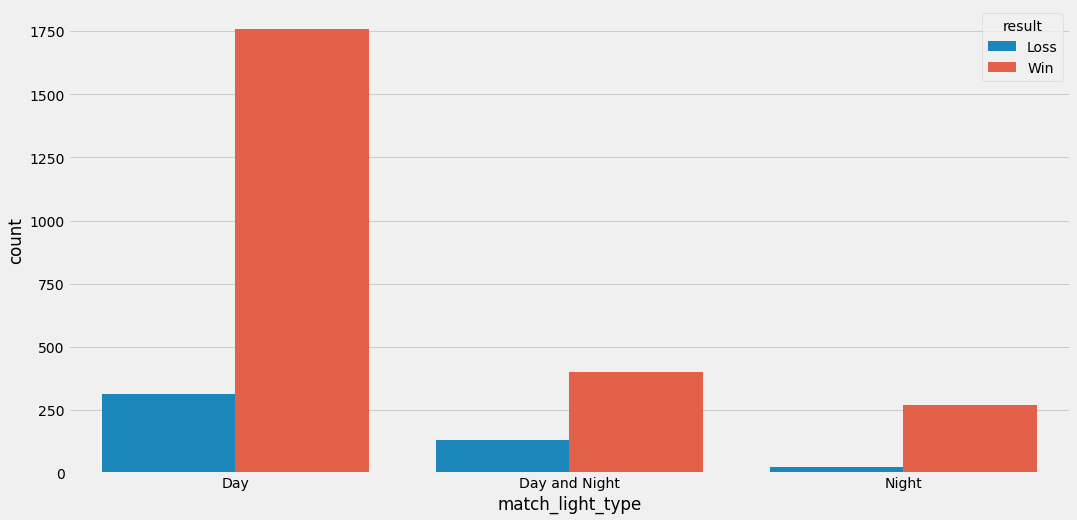

In [70]:
sns.countplot('match_light_type', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



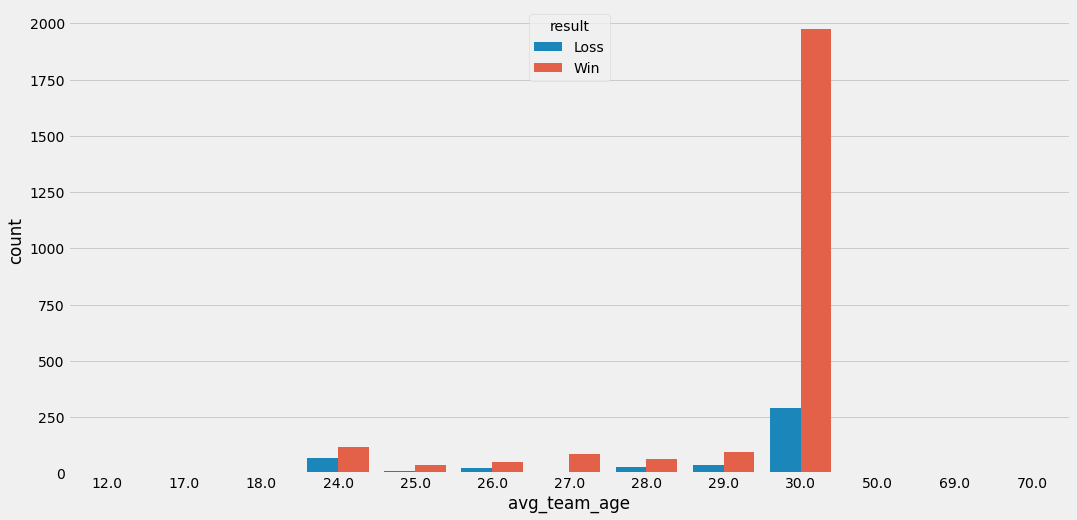

In [71]:
sns.countplot('avg_team_age', hue = 'result' , data = df_maindata)
plt.show()

Observation:
- avg_age_team has outliers. Average age for any team cannot be 12 or 70. Either its a mistake or outliers.
- India win most matches in avg_age 30. 
- Day time matches are beneficial for us.

### **Treating the outliers**
- **Capping and Flooring the outliers**



In [72]:
percentiles = df_maindata['avg_team_age'].quantile([0.01, 0.99]).values
df_maindata['avg_team_age'] = np.clip(df_maindata['avg_team_age'], percentiles[0], percentiles[1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



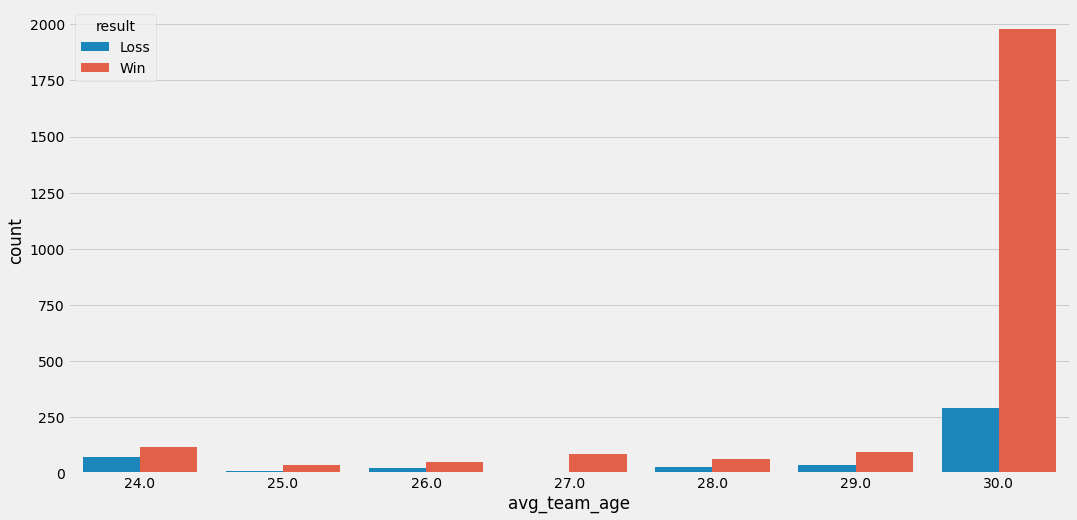

In [73]:
sns.countplot('avg_team_age', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

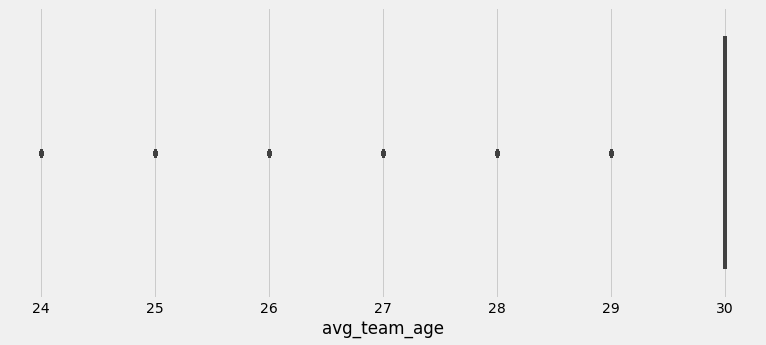

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

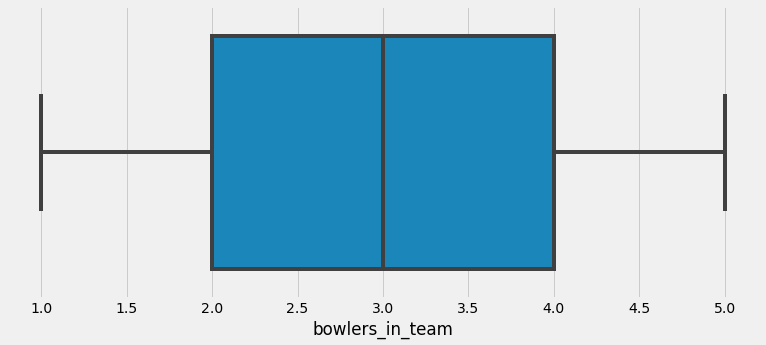

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



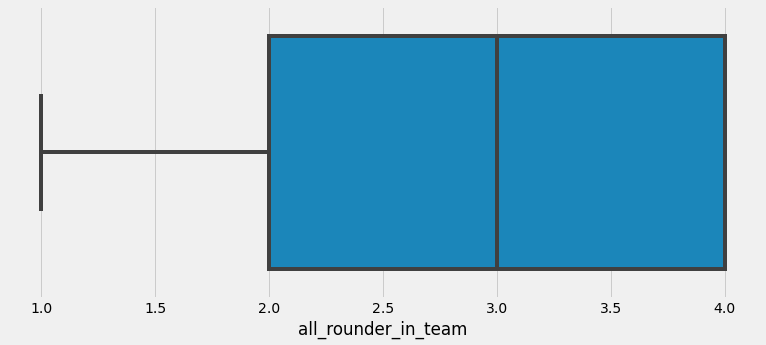

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

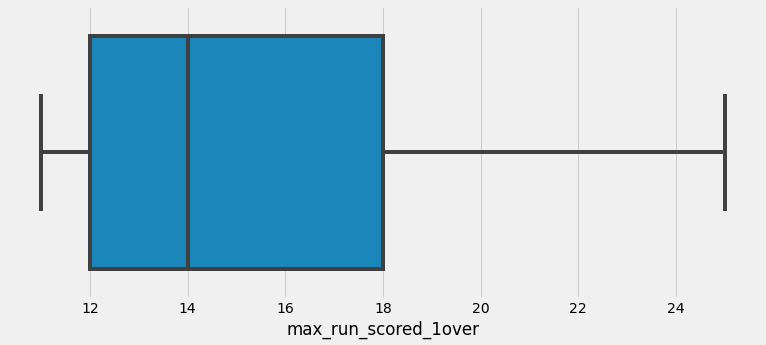

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



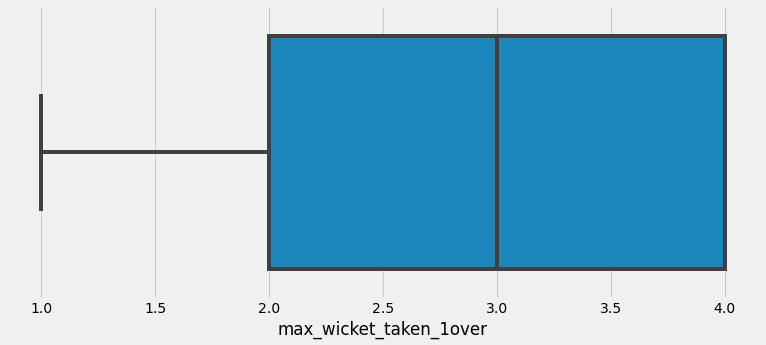

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



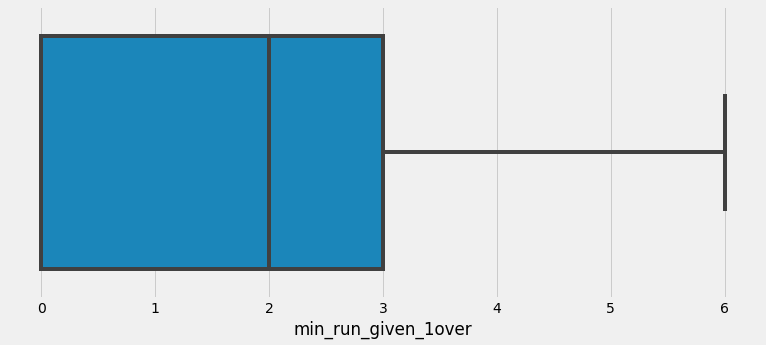

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



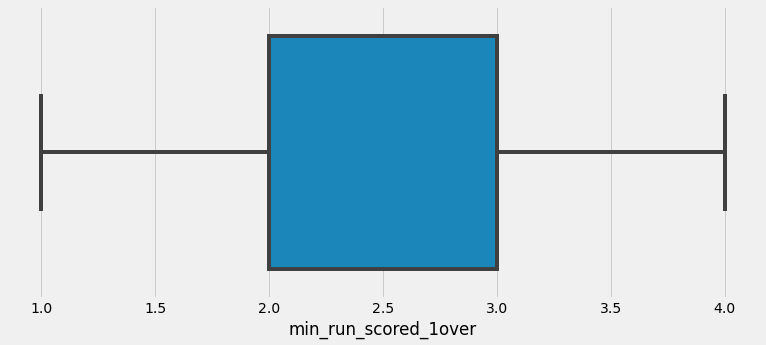

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



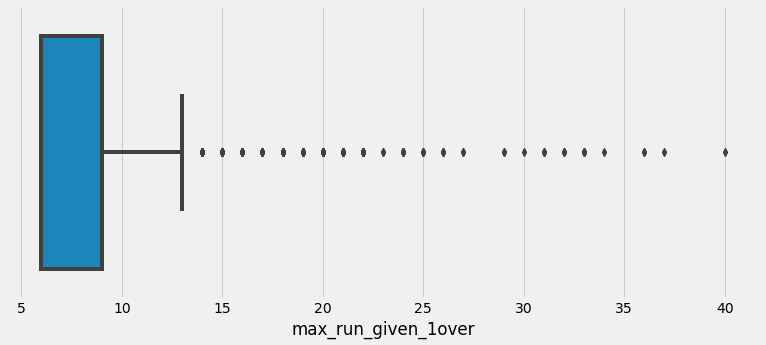

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



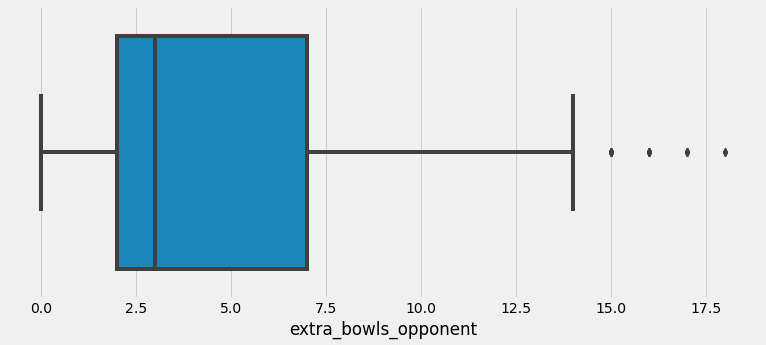

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



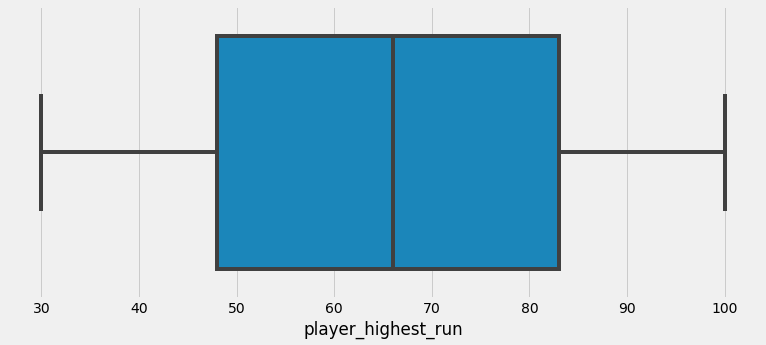

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



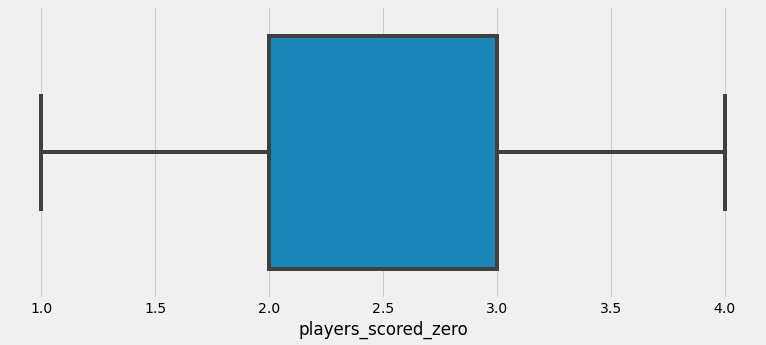

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



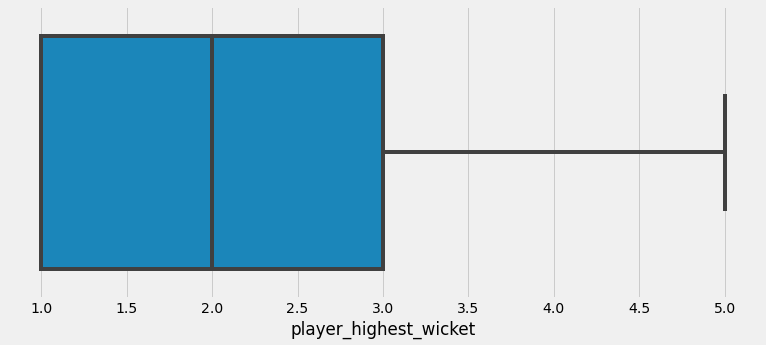

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



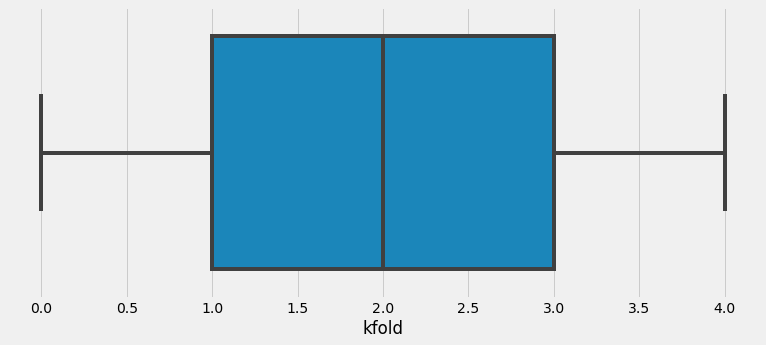

In [74]:
for col in df_maindata.columns:
  plt.figure(figsize = (12,5))
  if df_maindata[col].dtype != 'object':
    sns.boxplot(df_maindata[col])
    plt.show()

## **Let's work with Cardinality**

In [75]:
for col in df_maindata.columns:
  print(col)
  print(f"First 5 Unique Values: {df_maindata[col].unique()[:5]}")
  print(f"Number of unique values: {df_maindata[col].nunique()}")

  print('\n')

game_number
First 5 Unique Values: ['Game_1' 'Game_2' 'Game_3' 'Game_4' 'Game_5']
Number of unique values: 2894


result
First 5 Unique Values: ['Loss' 'Win']
Number of unique values: 2


avg_team_age
First 5 Unique Values: [24. 30. 25. 26. 27.]
Number of unique values: 7


match_light_type
First 5 Unique Values: ['Day' 'Day and Night' 'Night']
Number of unique values: 3


match_format
First 5 Unique Values: ['ODI' 'T20' 'Test']
Number of unique values: 3


bowlers_in_team
First 5 Unique Values: [3. 2. 1. 4. 5.]
Number of unique values: 5


all_rounder_in_team
First 5 Unique Values: [3. 4. 2. 1.]
Number of unique values: 4


first_selection
First 5 Unique Values: ['Bowling' 'Batting']
Number of unique values: 2


opponent
First 5 Unique Values: ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England']
Number of unique values: 9


season
First 5 Unique Values: ['Summer' 'Rainy' 'Winter']
Number of unique values: 3


offshore
First 5 Unique Values: ['No' 'Yes']
Number of unique values: 2


m

### **Observation:**

---
- We can One Hot Encode variables with 3 unique values
- Drop audience_number as it doesn't contribute much towards the predictions.


In [76]:
useful_cols = [col for col in df_maindata.columns if col not in ['game_number', 'result', 'kfold']]
categorical = [col for col in useful_cols if df_maindata[col].dtype == 'object']
numerical = [col for col in useful_cols if col not in categorical]

In [77]:
ohe_list = []
for col in df_maindata[useful_cols].columns:
  if df_maindata[useful_cols][col].nunique() <= 3:
    ohe_list.append(col) 

ohe_list

['match_light_type', 'match_format', 'first_selection', 'season', 'offshore']

In [78]:
for col in ohe_list:
  dummies = pd.get_dummies(df_maindata[col], prefix=col)
  df_maindata[dummies.columns] = dummies

In [79]:
df_maindata.drop(ohe_list, axis = 1, inplace=True )
df_maindata.drop('game_number', axis = 1, inplace=True)

In [80]:
df_maindata['result'] = df_maindata['result'].apply(lambda x: 1 if x == 'Win' else 0)

In [81]:
useful_cols = [col for col in df_maindata.columns if col not in ['game_number', 'result' ,'kfold']]
categorical = [col for col in useful_cols if df_maindata[col].dtype == 'object']
numerical = [col for col in useful_cols if col not in categorical]

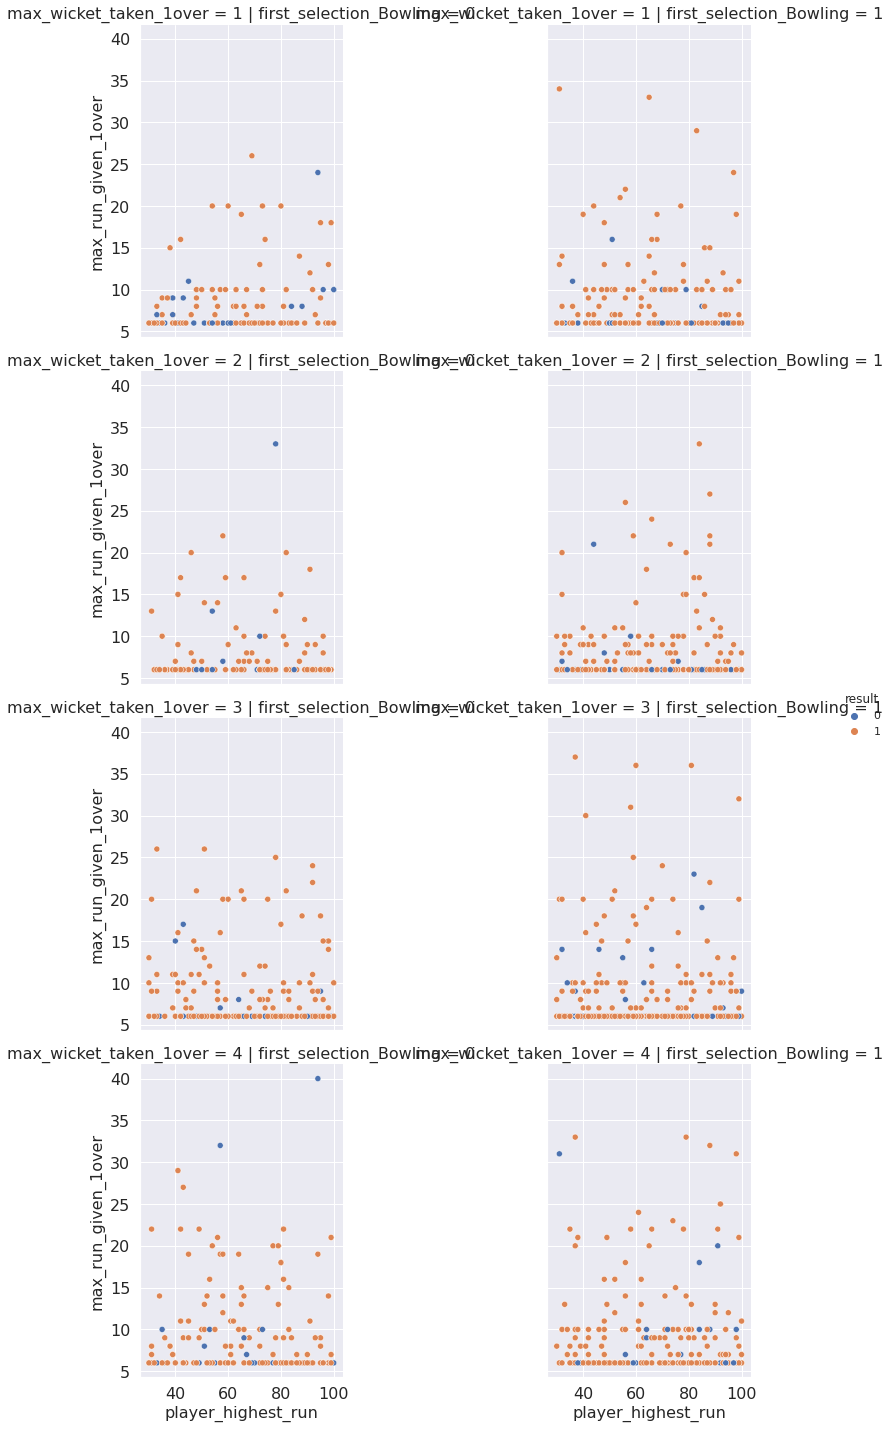

In [82]:
sns.set(rc={'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16})
sns.relplot(x="player_highest_run", y="max_run_given_1over",col="first_selection_Bowling", row="max_wicket_taken_1over", hue='result',  data=df_maindata)
plt.show()

In [83]:
for col in df_maindata.columns:
  print(col)
  print(f"First 5 Unique Values: {df_maindata[col].unique()[:5]}")
  print(f"Number of unique values: {df_maindata[col].nunique()}")

  print('\n')

result
First 5 Unique Values: [0 1]
Number of unique values: 2


avg_team_age
First 5 Unique Values: [24. 30. 25. 26. 27.]
Number of unique values: 7


bowlers_in_team
First 5 Unique Values: [3. 2. 1. 4. 5.]
Number of unique values: 5


all_rounder_in_team
First 5 Unique Values: [3. 4. 2. 1.]
Number of unique values: 4


opponent
First 5 Unique Values: ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England']
Number of unique values: 9


max_run_scored_1over
First 5 Unique Values: [13. 12. 14. 15. 16.]
Number of unique values: 15


max_wicket_taken_1over
First 5 Unique Values: [3 1 4 2]
Number of unique values: 4


min_run_given_1over
First 5 Unique Values: [2 0 5 4 3]
Number of unique values: 7


min_run_scored_1over
First 5 Unique Values: [3. 4. 1. 2.]
Number of unique values: 4


max_run_given_1over
First 5 Unique Values: [ 6.  7.  8.  9. 10.]
Number of unique values: 31


extra_bowls_opponent
First 5 Unique Values: [0 1 2 3 4]
Number of unique values: 19


player_highest_run
First 5 Un

In [84]:
df, df_test1 = train_test_split(df_maindata, stratify=df_maindata['result'], test_size = 0.15, random_state = 7)

## **HyperTuning first Model**

In [85]:
def run(trial):

    for fold in range(5):
        xtrain =  df[df.kfold != fold].reset_index(drop=True)
        xvalid = df[df.kfold == fold].reset_index(drop=True)

        ytrain = xtrain.result
        yvalid = xvalid.result
        
        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]
        
        train_dicts =xtrain.to_dict(orient='records')
        val_dicts = xvalid.to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        xtrain = dv.fit_transform(train_dicts)
        xvalid = dv.transform(val_dicts)
        
        # Optuna suggest params


        params = {
        'n_estimators': trial.suggest_int('n_estimators', 7000, 9000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_float('gamma', 0, 0.001)}
        
        model_xgb = XGBClassifier(**params, random_state=7)
        
        
        model_xgb.fit(xtrain, ytrain, early_stopping_rounds=300,eval_set=[(xvalid, yvalid)],  verbose=500)
        
        preds_valid = model_xgb.predict_proba(xvalid)[:, 1]
        roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    
        
    return roc_auc


study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=20)

study.best_params

[I 2021-11-02 15:48:46,627] A new study created in memory with name: no-name-571d59ab-d19d-404d-bfcb-a45faa18882b


[0]	validation_0-error:0.129897
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053608
Stopping. Best iteration:
[622]	validation_0-error:0.043299

[0]	validation_0-error:0.132797
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060362
[1000]	validation_0-error:0.04829
Stopping. Best iteration:
[893]	validation_0-error:0.04829

[0]	validation_0-error:0.147638
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05315
Stopping. Best iteration:
[561]	validation_0-error:0.049213

[0]	validation_0-error:0.146998
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05176
Stopping. Best iteration:
[537]	validation_0-error:0.047619

[0]	validation_0-error:0.133745
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.076132
[1000]	validation_0-error:0.067901
Stopping. Best iteration:

[I 2021-11-02 15:49:02,188] Trial 0 finished with value: 0.9347355586038715 and parameters: {'n_estimators': 8314, 'max_depth': 5, 'learning_rate': 0.04434918245960726, 'subsample': 0.8974666021779789, 'colsample_bytree': 0.6171514409604252, 'gamma': 0.0006308060792250883}. Best is trial 0 with value: 0.9347355586038715.


[0]	validation_0-error:0.131959
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.047423
Stopping. Best iteration:
[411]	validation_0-error:0.045361

[0]	validation_0-error:0.142857
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.052314
Stopping. Best iteration:
[541]	validation_0-error:0.04829

[0]	validation_0-error:0.133858
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.062992
Stopping. Best iteration:
[431]	validation_0-error:0.059055

[0]	validation_0-error:0.161491
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.047619
Stopping. Best iteration:
[410]	validation_0-error:0.047619

[0]	validation_0-error:0.144033
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.069959
[1000]	validation_0-error:0.067901
Stopping. Best iteration:
[842]	validation_0-error:0.0658

[I 2021-11-02 15:49:23,318] Trial 1 finished with value: 0.9385764365188233 and parameters: {'n_estimators': 7788, 'max_depth': 6, 'learning_rate': 0.0400990124918965, 'subsample': 0.6355244333365588, 'colsample_bytree': 0.9695130264464145, 'gamma': 0.00032436004391468785}. Best is trial 1 with value: 0.9385764365188233.


[0]	validation_0-error:0.146392
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.074227
[1000]	validation_0-error:0.059794
[1500]	validation_0-error:0.051546
Stopping. Best iteration:
[1410]	validation_0-error:0.049485

[0]	validation_0-error:0.152918
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070423
[1000]	validation_0-error:0.05835
Stopping. Best iteration:
[1012]	validation_0-error:0.052314

[0]	validation_0-error:0.153543
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.088583
[1000]	validation_0-error:0.062992
Stopping. Best iteration:
[737]	validation_0-error:0.059055

[0]	validation_0-error:0.153209
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066253
[1000]	validation_0-error:0.062112
Stopping. Best iteration:
[746]	validation_0-error:0.055901

[0]	validation_0-error:0.146091
Will train until

[I 2021-11-02 15:49:41,355] Trial 2 finished with value: 0.9387593354671544 and parameters: {'n_estimators': 7730, 'max_depth': 3, 'learning_rate': 0.08862347700999847, 'subsample': 0.8217876684139394, 'colsample_bytree': 0.8998116584185784, 'gamma': 0.00047007911846725904}. Best is trial 2 with value: 0.9387593354671544.


[0]	validation_0-error:0.131959
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.051546
Stopping. Best iteration:
[361]	validation_0-error:0.049485

[0]	validation_0-error:0.136821
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046278
Stopping. Best iteration:
[427]	validation_0-error:0.046278

[0]	validation_0-error:0.135827
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057087
Stopping. Best iteration:
[390]	validation_0-error:0.051181

[0]	validation_0-error:0.132505
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.055901
Stopping. Best iteration:
[298]	validation_0-error:0.047619

[0]	validation_0-error:0.148148
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.072016
Stopping. Best iteration:
[657]	validation_0-error:0.069959



[I 2021-11-02 15:49:54,444] Trial 3 finished with value: 0.9352232891327541 and parameters: {'n_estimators': 8933, 'max_depth': 6, 'learning_rate': 0.054295453193035956, 'subsample': 0.9187302981009771, 'colsample_bytree': 0.642829089651276, 'gamma': 0.00040387120002743606}. Best is trial 2 with value: 0.9387593354671544.


[0]	validation_0-error:0.152577
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.047423
Stopping. Best iteration:
[433]	validation_0-error:0.043299

[0]	validation_0-error:0.152918
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046278
Stopping. Best iteration:
[455]	validation_0-error:0.046278

[0]	validation_0-error:0.124016
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[183]	validation_0-error:0.064961

[0]	validation_0-error:0.151139
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060041
Stopping. Best iteration:
[241]	validation_0-error:0.049689

[0]	validation_0-error:0.141975
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.069959
Stopping. Best iteration:
[290]	validation_0-error:0.067901



[I 2021-11-02 15:50:09,933] Trial 4 finished with value: 0.9385764365188235 and parameters: {'n_estimators': 8375, 'max_depth': 6, 'learning_rate': 0.07696690142406598, 'subsample': 0.6852958826805655, 'colsample_bytree': 0.9752653511722804, 'gamma': 0.0005006267337256708}. Best is trial 2 with value: 0.9387593354671544.


[0]	validation_0-error:0.158763
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.098969
[1000]	validation_0-error:0.078351
[1500]	validation_0-error:0.065979
Stopping. Best iteration:
[1302]	validation_0-error:0.059794

[0]	validation_0-error:0.156942
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.112676
[1000]	validation_0-error:0.082495
[1500]	validation_0-error:0.062374
[2000]	validation_0-error:0.056338
Stopping. Best iteration:
[1784]	validation_0-error:0.054326

[0]	validation_0-error:0.153543
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.112205
[1000]	validation_0-error:0.086614
[1500]	validation_0-error:0.072835
Stopping. Best iteration:
[1489]	validation_0-error:0.070866

[0]	validation_0-error:0.161491
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.091097
[1000]	validation_0-error:0.074534
[1

[I 2021-11-02 15:50:37,444] Trial 5 finished with value: 0.9249199817101053 and parameters: {'n_estimators': 8299, 'max_depth': 3, 'learning_rate': 0.03876924710278066, 'subsample': 0.6269233869618522, 'colsample_bytree': 0.9207055800155213, 'gamma': 0.00031588786621512523}. Best is trial 2 with value: 0.9387593354671544.


[0]	validation_0-error:0.148454
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053608
Stopping. Best iteration:
[573]	validation_0-error:0.045361

[0]	validation_0-error:0.148893
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.054326
[1000]	validation_0-error:0.044266
Stopping. Best iteration:
[760]	validation_0-error:0.044266

[0]	validation_0-error:0.155512
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.072835
Stopping. Best iteration:
[492]	validation_0-error:0.070866

[0]	validation_0-error:0.161491
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057971
[1000]	validation_0-error:0.057971
Stopping. Best iteration:
[833]	validation_0-error:0.05176

[0]	validation_0-error:0.144033
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.067901
[1000]	validation_0-er

[I 2021-11-02 15:50:53,578] Trial 6 finished with value: 0.9344307270233196 and parameters: {'n_estimators': 7513, 'max_depth': 4, 'learning_rate': 0.08920122454155541, 'subsample': 0.5311929733598948, 'colsample_bytree': 0.6889984194062136, 'gamma': 0.0008461026285471236}. Best is trial 2 with value: 0.9387593354671544.


[0]	validation_0-error:0.129897
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.096907
[1000]	validation_0-error:0.078351
[1500]	validation_0-error:0.061856
Stopping. Best iteration:
[1429]	validation_0-error:0.059794

[0]	validation_0-error:0.140845
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.10664
[1000]	validation_0-error:0.088531
[1500]	validation_0-error:0.066398
[2000]	validation_0-error:0.05835
[2500]	validation_0-error:0.052314
Stopping. Best iteration:
[2408]	validation_0-error:0.052314

[0]	validation_0-error:0.143701
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[140]	validation_0-error:0.112205

[0]	validation_0-error:0.144928
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.089027
[1000]	validation_0-error:0.066253
[1500]	validation_0-error:0.055901
[2000]	validation_0-error:0.047619
Stop

[I 2021-11-02 15:51:18,748] Trial 7 finished with value: 0.9296753543667124 and parameters: {'n_estimators': 7571, 'max_depth': 4, 'learning_rate': 0.018688078604332862, 'subsample': 0.8245891736693505, 'colsample_bytree': 0.7048050138264637, 'gamma': 0.0001274886874341594}. Best is trial 2 with value: 0.9387593354671544.


[0]	validation_0-error:0.125773
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.051546
Stopping. Best iteration:
[448]	validation_0-error:0.051546

[0]	validation_0-error:0.130785
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04829
Stopping. Best iteration:
[433]	validation_0-error:0.04829

[0]	validation_0-error:0.137795
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057087
Stopping. Best iteration:
[378]	validation_0-error:0.05315

[0]	validation_0-error:0.149068
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.062112
Stopping. Best iteration:
[327]	validation_0-error:0.05176

[0]	validation_0-error:0.135802
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.069959
Stopping. Best iteration:
[475]	validation_0-error:0.067901



[I 2021-11-02 15:51:29,721] Trial 8 finished with value: 0.9332418838591678 and parameters: {'n_estimators': 8430, 'max_depth': 5, 'learning_rate': 0.06875732559962336, 'subsample': 0.8338983867464143, 'colsample_bytree': 0.5336429842773951, 'gamma': 0.000531126158373412}. Best is trial 2 with value: 0.9387593354671544.


[0]	validation_0-error:0.129897
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.051546
Stopping. Best iteration:
[257]	validation_0-error:0.041237

[0]	validation_0-error:0.152918
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.050302
Stopping. Best iteration:
[240]	validation_0-error:0.04829

[0]	validation_0-error:0.129921
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[171]	validation_0-error:0.057087

[0]	validation_0-error:0.144928
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[159]	validation_0-error:0.049689

[0]	validation_0-error:0.139918
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.067901
Stopping. Best iteration:
[327]	validation_0-error:0.065844



[I 2021-11-02 15:51:41,831] Trial 9 finished with value: 0.9384240207285475 and parameters: {'n_estimators': 8865, 'max_depth': 6, 'learning_rate': 0.08769777253179237, 'subsample': 0.7894954736310176, 'colsample_bytree': 0.9138722347326775, 'gamma': 0.0003179873652352101}. Best is trial 2 with value: 0.9387593354671544.


[0]	validation_0-error:0.129897
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.113402
Stopping. Best iteration:
[689]	validation_0-error:0.109278

[0]	validation_0-error:0.152918
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.126761
Stopping. Best iteration:
[564]	validation_0-error:0.118712

[0]	validation_0-error:0.149606
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[45]	validation_0-error:0.133858

[0]	validation_0-error:0.153209
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.118012
[1000]	validation_0-error:0.101449
[1500]	validation_0-error:0.089027
[2000]	validation_0-error:0.078675
[2500]	validation_0-error:0.072464
Stopping. Best iteration:
[2666]	validation_0-error:0.070393

[0]	validation_0-error:0.148148
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iter

[I 2021-11-02 15:51:55,216] Trial 10 finished with value: 0.7574150281969212 and parameters: {'n_estimators': 7066, 'max_depth': 3, 'learning_rate': 0.010863100203778293, 'subsample': 0.9852437329413986, 'colsample_bytree': 0.8327496836164385, 'gamma': 0.0009665918041178786}. Best is trial 2 with value: 0.9387593354671544.


[0]	validation_0-error:0.150515
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057732
Stopping. Best iteration:
[544]	validation_0-error:0.051546

[0]	validation_0-error:0.136821
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.054326
Stopping. Best iteration:
[686]	validation_0-error:0.04829

[0]	validation_0-error:0.141732
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.062992
Stopping. Best iteration:
[613]	validation_0-error:0.057087

[0]	validation_0-error:0.169772
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057971
Stopping. Best iteration:
[515]	validation_0-error:0.05383

[0]	validation_0-error:0.150206
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.074074
Stopping. Best iteration:
[683]	validation_0-error:0.065844



[I 2021-11-02 15:52:10,355] Trial 11 finished with value: 0.9388203017832647 and parameters: {'n_estimators': 8039, 'max_depth': 4, 'learning_rate': 0.07257666354440809, 'subsample': 0.6976562206267667, 'colsample_bytree': 0.8189240830392842, 'gamma': 0.0006621787966413847}. Best is trial 11 with value: 0.9388203017832647.


[0]	validation_0-error:0.150515
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.080412
[1000]	validation_0-error:0.05567
Stopping. Best iteration:
[890]	validation_0-error:0.053608

[0]	validation_0-error:0.158954
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.076459
[1000]	validation_0-error:0.052314
Stopping. Best iteration:
[1123]	validation_0-error:0.046278

[0]	validation_0-error:0.153543
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.080709
[1000]	validation_0-error:0.061024
Stopping. Best iteration:
[756]	validation_0-error:0.059055

[0]	validation_0-error:0.15735
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066253
Stopping. Best iteration:
[638]	validation_0-error:0.057971

[0]	validation_0-error:0.152263
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-er

[I 2021-11-02 15:52:28,093] Trial 12 finished with value: 0.9386069196768786 and parameters: {'n_estimators': 7964, 'max_depth': 3, 'learning_rate': 0.09870289593505857, 'subsample': 0.7376953622426435, 'colsample_bytree': 0.8072884588871189, 'gamma': 0.0006901304194960237}. Best is trial 11 with value: 0.9388203017832647.


[0]	validation_0-error:0.160825
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.059794
Stopping. Best iteration:
[646]	validation_0-error:0.053608

[0]	validation_0-error:0.136821
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060362
Stopping. Best iteration:
[670]	validation_0-error:0.044266

[0]	validation_0-error:0.141732
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.061024
Stopping. Best iteration:
[464]	validation_0-error:0.059055

[0]	validation_0-error:0.15942
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.055901
Stopping. Best iteration:
[454]	validation_0-error:0.047619

[0]	validation_0-error:0.146091
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.074074
[1000]	validation_0-error:0.074074
Stopping. Best iteration:
[706]	validation_0-error:0.0679

[I 2021-11-02 15:52:43,057] Trial 13 finished with value: 0.9376314586191129 and parameters: {'n_estimators': 7174, 'max_depth': 4, 'learning_rate': 0.06970188134848235, 'subsample': 0.730042974056332, 'colsample_bytree': 0.8292112344855873, 'gamma': 0.0007809144840850887}. Best is trial 11 with value: 0.9388203017832647.


[0]	validation_0-error:0.158763
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.090722
[1000]	validation_0-error:0.068041
Stopping. Best iteration:
[825]	validation_0-error:0.061856

[0]	validation_0-error:0.158954
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.100604
[1000]	validation_0-error:0.070423
Stopping. Best iteration:
[741]	validation_0-error:0.066398

[0]	validation_0-error:0.159449
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.106299
[1000]	validation_0-error:0.082677
[1500]	validation_0-error:0.070866
Stopping. Best iteration:
[1478]	validation_0-error:0.066929

[0]	validation_0-error:0.161491
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.091097
[1000]	validation_0-error:0.066253
Stopping. Best iteration:
[988]	validation_0-error:0.062112

[0]	validation_0-error:0.156379
Will train until

[I 2021-11-02 15:53:02,689] Trial 14 finished with value: 0.928547477518671 and parameters: {'n_estimators': 8007, 'max_depth': 3, 'learning_rate': 0.060737667584128144, 'subsample': 0.5237310280731347, 'colsample_bytree': 0.7775948634373976, 'gamma': 1.1920511419981621e-05}. Best is trial 11 with value: 0.9388203017832647.


[0]	validation_0-error:0.146392
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05567
Stopping. Best iteration:
[496]	validation_0-error:0.051546

[0]	validation_0-error:0.138833
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.052314
[1000]	validation_0-error:0.04829
Stopping. Best iteration:
[844]	validation_0-error:0.046278

[0]	validation_0-error:0.141732
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.061024
Stopping. Best iteration:
[480]	validation_0-error:0.059055

[0]	validation_0-error:0.146998
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.047619
Stopping. Best iteration:
[599]	validation_0-error:0.045549

[0]	validation_0-error:0.152263
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.072016
Stopping. Best iteration:
[620]	validation_0-error:0.06584

[I 2021-11-02 15:53:19,083] Trial 15 finished with value: 0.9366255144032922 and parameters: {'n_estimators': 7450, 'max_depth': 4, 'learning_rate': 0.08203520693691309, 'subsample': 0.6512646698051889, 'colsample_bytree': 0.8547261396574234, 'gamma': 0.0006441044731964143}. Best is trial 11 with value: 0.9388203017832647.


[0]	validation_0-error:0.156701
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053608
Stopping. Best iteration:
[297]	validation_0-error:0.051546

[0]	validation_0-error:0.134809
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044266
Stopping. Best iteration:
[314]	validation_0-error:0.044266

[0]	validation_0-error:0.139764
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.059055
Stopping. Best iteration:
[219]	validation_0-error:0.059055

[0]	validation_0-error:0.144928
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[199]	validation_0-error:0.049689

[0]	validation_0-error:0.139918
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.072016
Stopping. Best iteration:
[235]	validation_0-error:0.072016



[I 2021-11-02 15:53:29,695] Trial 16 finished with value: 0.9265660722450846 and parameters: {'n_estimators': 8006, 'max_depth': 5, 'learning_rate': 0.09610279957989208, 'subsample': 0.8643357256821295, 'colsample_bytree': 0.9042394626055489, 'gamma': 0.00018245796595032506}. Best is trial 11 with value: 0.9388203017832647.


[0]	validation_0-error:0.158763
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.082474
[1000]	validation_0-error:0.063918
Stopping. Best iteration:
[765]	validation_0-error:0.059794

[0]	validation_0-error:0.158954
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.096579
[1000]	validation_0-error:0.064386
[1500]	validation_0-error:0.050302
Stopping. Best iteration:
[1343]	validation_0-error:0.04829

[0]	validation_0-error:0.153543
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.09252
[1000]	validation_0-error:0.072835
Stopping. Best iteration:
[885]	validation_0-error:0.066929

[0]	validation_0-error:0.161491
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.076605
Stopping. Best iteration:
[674]	validation_0-error:0.062112

[0]	validation_0-error:0.154321
Will train until validation_0-error hasn't improved i

[I 2021-11-02 15:53:47,779] Trial 17 finished with value: 0.9319920743789056 and parameters: {'n_estimators': 7742, 'max_depth': 3, 'learning_rate': 0.07363447379608083, 'subsample': 0.5832035568018773, 'colsample_bytree': 0.7330093532975978, 'gamma': 0.0007972889804730321}. Best is trial 11 with value: 0.9388203017832647.


[0]	validation_0-error:0.152577
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05567
[1000]	validation_0-error:0.053608
Stopping. Best iteration:
[835]	validation_0-error:0.051546

[0]	validation_0-error:0.142857
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.064386
[1000]	validation_0-error:0.050302
Stopping. Best iteration:
[833]	validation_0-error:0.044266

[0]	validation_0-error:0.141732
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.061024
Stopping. Best iteration:
[637]	validation_0-error:0.055118

[0]	validation_0-error:0.149068
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060041
[1000]	validation_0-error:0.060041
Stopping. Best iteration:
[780]	validation_0-error:0.05176

[0]	validation_0-error:0.139918
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-err

[I 2021-11-02 15:54:05,670] Trial 18 finished with value: 0.9396738302088097 and parameters: {'n_estimators': 7329, 'max_depth': 4, 'learning_rate': 0.06289221257624072, 'subsample': 0.7759707778321282, 'colsample_bytree': 0.8766177082989756, 'gamma': 0.0005749436953296644}. Best is trial 18 with value: 0.9396738302088097.


[0]	validation_0-error:0.150515
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.084536
[1000]	validation_0-error:0.057732
Stopping. Best iteration:
[975]	validation_0-error:0.057732

[0]	validation_0-error:0.136821
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.092555
[1000]	validation_0-error:0.064386
[1500]	validation_0-error:0.050302
Stopping. Best iteration:
[1430]	validation_0-error:0.04829

[0]	validation_0-error:0.141732
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.094488
[1000]	validation_0-error:0.064961
[1500]	validation_0-error:0.057087
Stopping. Best iteration:
[1204]	validation_0-error:0.055118

[0]	validation_0-error:0.151139
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.078675
[1000]	validation_0-error:0.060041
Stopping. Best iteration:
[778]	validation_0-error:0.057971

[0]	validatio

[I 2021-11-02 15:54:29,938] Trial 19 finished with value: 0.9351318396585886 and parameters: {'n_estimators': 8633, 'max_depth': 4, 'learning_rate': 0.031094266938836608, 'subsample': 0.6954024095734488, 'colsample_bytree': 0.7739998476968507, 'gamma': 0.0005821298069602953}. Best is trial 18 with value: 0.9396738302088097.


{'colsample_bytree': 0.8766177082989756,
 'gamma': 0.0005749436953296644,
 'learning_rate': 0.06289221257624072,
 'max_depth': 4,
 'n_estimators': 7329,
 'subsample': 0.7759707778321282}

In [86]:

df_test = df_test1[useful_cols]
final_test_predictions = []
final_valid_predictions = {}
decisions_valid = []
decisions_test = [] 
scores = []
for fold in range(5):
    xtrain =  df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test1.copy()
    
    valid_ids = xvalid.index.values.tolist()

    ytrain = xtrain.result
    yvalid = xvalid.result
    
    xtrain = xtrain[useful_cols]
    xvalid = xvalid[useful_cols]
    xtest = xtest[useful_cols]
    
    train_dicts = xtrain.to_dict(orient='records')
    val_dicts = xvalid.to_dict(orient='records')
    test_dicts = xtest.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    xtrain = dv.fit_transform(train_dicts)
    xvalid = dv.transform(val_dicts)
    xtest = dv.transform(test_dicts)
    
    params = study.best_params
    
    
    model = XGBClassifier(n_estimators=2000,
        random_state=7
    )
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=500)
    preds_valid = model.predict_proba(xvalid)[:, 1]

    test_preds = model.predict_proba(xtest)[:1]

    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc)
    scores.append(roc_auc)
 
print(np.mean(scores), np.std(scores))

[0]	validation_0-error:0.127835
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.076289
[1000]	validation_0-error:0.063918
Stopping. Best iteration:
[1188]	validation_0-error:0.05567

0 0.9353637451788802
[0]	validation_0-error:0.150905
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.080483
[1000]	validation_0-error:0.062374
Stopping. Best iteration:
[815]	validation_0-error:0.05835

1 0.8763354700854701
[0]	validation_0-error:0.147638
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.086614
[1000]	validation_0-error:0.068898
Stopping. Best iteration:
[1077]	validation_0-error:0.062992

2 0.916409023245162
[0]	validation_0-error:0.151139
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070393
[1000]	validation_0-error:0.055901
Stopping. Best iteration:
[962]	validation_0-error:0.05176

3 0.9452674897119342
[0

## **Confusion Matrix and Classification reports for XGB model.**

In [87]:
from sklearn.metrics import confusion_matrix, classification_report
val_dicts = df_test.to_dict(orient='records')
df_test = dv.transform(val_dicts)
print(confusion_matrix(df_test1.result, model.predict(df_test)))
print(classification_report(df_test1.result, model.predict(df_test)))

[[ 43  27]
 [  8 357]]
              precision    recall  f1-score   support

           0       0.84      0.61      0.71        70
           1       0.93      0.98      0.95       365

    accuracy                           0.92       435
   macro avg       0.89      0.80      0.83       435
weighted avg       0.92      0.92      0.91       435



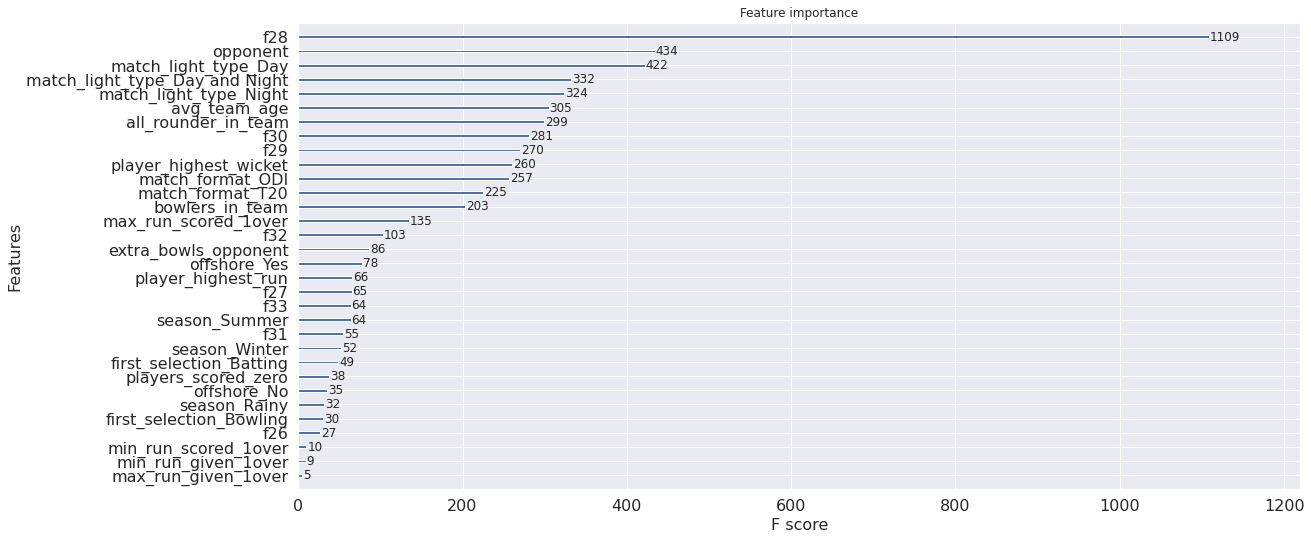

In [88]:
import xgboost as xgb
model.get_booster().feature_names = list(useful_cols)
xgb.plot_importance(model.get_booster())

In [89]:
from sklearn.ensemble import  RandomForestClassifier

## **Hyperparameter tuning Random Forest**

In [90]:
def run(trial):

    for fold in range(5):
        xtrain =  df[df.kfold != fold].reset_index(drop=True)
        xvalid = df[df.kfold == fold].reset_index(drop=True)

        ytrain = xtrain.result
        yvalid = xvalid.result
        
        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]
        
        train_dicts =xtrain.to_dict(orient='records')
        val_dicts = xvalid.to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        xtrain = dv.fit_transform(train_dicts)
        xvalid = dv.transform(val_dicts)
        
        # Optuna suggest params
        params = {
        'n_estimators':  trial.suggest_int("n_estimators", 2, 7000),
        'max_depth': int(trial.suggest_loguniform('max_depth', 1, 32))}


        
        model_rf = RandomForestClassifier(**params, random_state=7)
        
        
        model_rf.fit(xtrain, ytrain)
        
        preds_valid = model_rf.predict_proba(xvalid)[:, 1]
        roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    
        
    return roc_auc


study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=20)

study.best_params

[I 2021-11-02 15:54:46,491] A new study created in memory with name: no-name-aad55a3f-d59b-42ae-91a3-79fe8457d784
[I 2021-11-02 15:55:01,386] Trial 0 finished with value: 0.7893308946806891 and parameters: {'n_estimators': 1826, 'max_depth': 2.69318762643557}. Best is trial 0 with value: 0.7893308946806891.
[I 2021-11-02 15:55:35,246] Trial 1 finished with value: 0.7886602652034751 and parameters: {'n_estimators': 4299, 'max_depth': 2.197716914810739}. Best is trial 0 with value: 0.7893308946806891.
[I 2021-11-02 15:55:51,356] Trial 2 finished with value: 0.7716963877457705 and parameters: {'n_estimators': 2134, 'max_depth': 1.0041276821202236}. Best is trial 0 with value: 0.7893308946806891.
[I 2021-11-02 15:56:05,322] Trial 3 finished with value: 0.788995579942082 and parameters: {'n_estimators': 1722, 'max_depth': 2.627770820533814}. Best is trial 0 with value: 0.7893308946806891.
[I 2021-11-02 15:57:15,625] Trial 4 finished with value: 0.9504496265813139 and parameters: {'n_estimat

{'max_depth': 30.46950813424396, 'n_estimators': 6669}

In [91]:

df_test = df_test1[useful_cols]
final_test_predictions = []
final_valid_predictions = {}
decisions_valid = []
decisions_test = [] 
scores = []
for fold in range(5):
    xtrain =  df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()
    
    valid_ids = xvalid.index.values.tolist()

    ytrain = xtrain.result
    yvalid = xvalid.result
    
    xtrain = xtrain[useful_cols]
    xvalid = xvalid[useful_cols]
    
    train_dicts = xtrain.to_dict(orient='records')
    val_dicts = xvalid.to_dict(orient='records')
    test_dicts = xtest.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    xtrain = dv.fit_transform(train_dicts)
    xvalid = dv.transform(val_dicts)
    xtest = dv.transform(test_dicts)
    
    params = study.best_params

    model = RandomForestClassifier(**params,
        random_state=7)
    model.fit(xtrain, ytrain)
    preds_valid = model.predict_proba(xvalid)[:, 1]

    test_preds = model.predict_proba(xtest)[:, 1]

    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc)
    scores.append(roc_auc)
 
print(np.mean(scores), np.std(scores))

0 0.9587212395265328
1 0.9186995489078822
2 0.9481134776136494
3 0.9784900284900286
4 0.9428898033836305
0.9493828195843447 0.019594230197290997


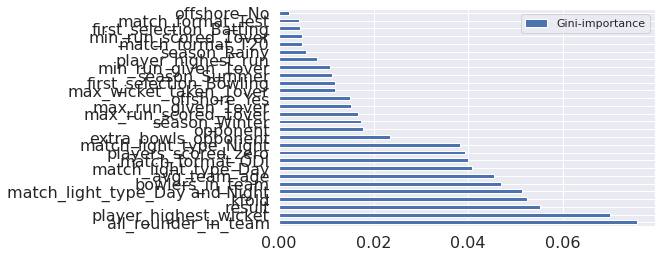

In [92]:
import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df_maindata.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

(importances.sort_values(by='Gini-importance', ascending = False)).plot(kind='barh')